In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [3]:
TOTAL_ROWS = 10000

COLUMNS = [
    'electrode force',
    'electrode contact surface diameter',
    'squeeze time',
    'weld time',
    'hold time',
    'weld current',
    'leak rate',
    'explosive force',
    'leaking',
    'explosion'
]

INPUT_COLUMNS = [
    'electrode force',
    'electrode contact surface diameter',
    'squeeze time',
    'weld time',
    'hold time',
    'weld current'
]

OUTPUT_COLUMNS = [
    'leak rate',
    'explosive force',
    'leaking',
    'explosion'
]

CATEGORICAL_LABELS = ['leaking', 'explosion']

In [4]:
def generate_coefficients(input_length, output_length):
    mean = 0
    stddev = 5.0
    rows = input_length
    columns = output_length
    return np.random.normal(mean, stddev, size=(rows, columns))

def generate_row(coefficients):
    rows, columns = coefficients.shape
    input_row = np.random.rand(columns)
    output = np.matmul(coefficients, input_row)
    output = output.tolist()
    assert len(output) >= 4
    output[-2] = "leaking" if output[-4] > 0 else "not leaking"
    output[-1] = "explosion" if output[-3] > 0 else "no explosion"
    output = input_row.tolist() + output
    return output

def generate_sets(myset, output_columns, categorical_labels):
    myset_labels = myset[output_columns].copy()
    myset = myset.drop(output_columns, axis=1)
    myset_categorical = myset_labels[categorical_labels]
    categorical_encoder = OneHotEncoder()
    myset_categorical = categorical_encoder.fit_transform(myset_categorical)
    myset_categorical = myset_categorical.toarray()
    return myset, myset_labels, myset_categorical, categorical_encoder

In [5]:
my_dataframe = pd.DataFrame(columns=COLUMNS)
coefficients = generate_coefficients(len(INPUT_COLUMNS), len(OUTPUT_COLUMNS))
for i in range(TOTAL_ROWS):
    my_dataframe.loc[len(my_dataframe)] = generate_row(coefficients)
print(my_dataframe.head())

   electrode force  electrode contact surface diameter  squeeze time  \
0         0.389669                            0.094160      0.695286   
1         0.670343                            0.815768      0.156309   
2         0.739572                            0.890730      0.737805   
3         0.578696                            0.358253      0.886858   
4         0.880160                            0.702583      0.490532   

   weld time  hold time  weld current  leak rate  explosive force  leaking  \
0   0.905132  10.360130      3.715172   3.017622         8.794391  leaking   
1   0.985270   7.689220      1.268376   4.881699        15.784624  leaking   
2   0.585895  11.049623      0.342335   2.434512        10.416735  leaking   
3   0.618554  11.459582      1.735881   1.998466         7.508179  leaking   
4   0.524486   8.864821     -1.346961   3.095410        11.536425  leaking   

   explosion  
0  explosion  
1  explosion  
2  explosion  
3  explosion  
4  explosion  


In [12]:
welding_train, welding_test = train_test_split(my_dataframe, test_size=0.2, random_state=42)
welding_train, welding_validation = train_test_split(welding_train)

welding_train_labels = welding_train[OUTPUT_COLUMNS].copy()
welding_train = welding_train.drop(OUTPUT_COLUMNS, axis=1)
welding_train_categorical = welding_train_labels[CATEGORICAL_LABELS]
welding_train_labels = welding_train_labels.drop(CATEGORICAL_LABELS, axis=1)
train_categorical_encoder = OneHotEncoder()
welding_train_categorical = train_categorical_encoder.fit_transform(welding_train_categorical)
welding_train_categorical = welding_train_categorical.toarray()

welding_test_labels = welding_test[OUTPUT_COLUMNS].copy()
welding_test = welding_test.drop(OUTPUT_COLUMNS, axis=1)
welding_test_categorical = welding_test_labels[CATEGORICAL_LABELS]
welding_test_labels = welding_test_labels.drop(CATEGORICAL_LABELS, axis=1)
test_categorical_encoder = OneHotEncoder()
welding_test_categorical = test_categorical_encoder.fit_transform(welding_test_categorical)
welding_test_categorical = welding_test_categorical.toarray()

welding_validation_labels = welding_validation[OUTPUT_COLUMNS].copy()
welding_validation = welding_validation.drop(OUTPUT_COLUMNS, axis=1)
welding_validation_categorical = welding_validation_labels[CATEGORICAL_LABELS]
welding_validation_labels = welding_validation_labels.drop(CATEGORICAL_LABELS, axis=1)
validation_categorical_encoder = OneHotEncoder()
welding_validation_categorical = validation_categorical_encoder.fit_transform(welding_validation_categorical)
welding_validation_categorical = welding_validation_categorical.toarray()

scaler = StandardScaler()
welding_train = scaler.fit_transform(welding_train)
welding_test = scaler.transform(welding_test)
welding_validation = scaler.transform(welding_validation)

print(welding_train_categorical[:10])
print(train_categorical_encoder.categories_)

[[1. 0. 1. 0.]
 [1. 0. 1. 0.]
 [1. 0. 1. 0.]
 [1. 0. 1. 0.]
 [1. 0. 1. 0.]
 [1. 0. 1. 0.]
 [1. 0. 1. 0.]
 [1. 0. 1. 0.]
 [1. 0. 1. 0.]
 [1. 0. 1. 0.]]
[array(['leaking', 'not leaking'], dtype=object), array(['explosion', 'no explosion'], dtype=object)]


In [13]:
import tensorflow as tf
from tensorflow import keras

In [14]:
INPUT_WIDTH = len(INPUT_COLUMNS)
OUTPUT_WIDTH = len(OUTPUT_COLUMNS)
numerical_output_width = welding_train_labels.shape[1]
categorical_output_width = welding_train_categorical.shape[1]

In [16]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=(INPUT_WIDTH,)))
model.add(keras.layers.Dense(INPUT_WIDTH * 10, activation="relu"))
model.add(keras.layers.Dense(INPUT_WIDTH * 5, activation="relu"))
model.add(keras.layers.Dense(INPUT_WIDTH * 1, activation="relu"))
#model.add(keras.layers.Dense(numerical_output_width, activation="softmax"))
model.add(keras.layers.Dense(numerical_output_width))
#model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
model.compile(loss="mse", optimizer="adam", metrics=["mse"])
history = model.fit(welding_train,
    welding_train_labels,
    epochs=30,
    validation_data=(welding_validation, welding_validation_labels))
mse_test = model.evaluate(welding_test, welding_test_labels)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 23.5055 - mse: 23.5055 - val_loss: 0.9671 - val_mse: 0.9671
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8311 - mse: 0.8311 - val_loss: 0.4338 - val_mse: 0.4338
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3431 - mse: 0.3431 - val_loss: 0.1487 - val_mse: 0.1487
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1072 - mse: 0.1072 - val_loss: 0.0360 - val_mse: 0.0360
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0270 - mse: 0.0270 - val_loss: 0.0162 - val_mse: 0.0162
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0148 - mse: 0.0148 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0090 - mse: 0.0090 - val_loss: 0.0080 - val_mse: 0.0080
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 9/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - 

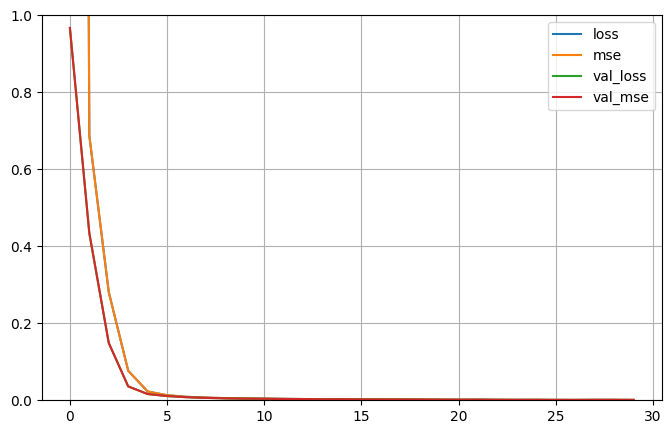

In [18]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()